<a id='content'></a>

**Декомпозиция:**

- [1. Обзор данных](#1)
- [2. Предобработка данных](#2)
- [3. Анализ данных](#3)
- [4. Презентация](#4)


In [1]:
# добавим необходимые библиотеки

import pandas as pd
pd.set_option('display.max_colwidth', None)

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

In [2]:
# зададим общий стиль 

sns.set_style('darkgrid')
sns.set_palette('deep') 

In [3]:
# добавим внешние данные по общепитам Москвы

from io import BytesIO
import requests
spreadsheet_id = '1eKGwwU6tMMI9ILA-U3xe7oXZONrbUzOohkxqTiAb248'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
df = pd.read_csv(BytesIO(r.content))

<a id='1'></a>
## [1. Обзор данных](#content)



In [4]:
# откроем данные и положим их в переменную rest_data

try:
    rest_data = pd.read_csv('data/rest_data.csv')
except:
    rest_data = pd.read_csv('link to the file')

In [5]:
# изучим данные

display(rest_data.head(), rest_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


None

**Описание данных** таблицы rest_data:
- `id` — идентификатор объекта;
- `object_name` — название объекта общественного питания;
- `chain` — сетевой ресторан;
- `object_type` — тип объекта общественного питания;
- `address` — адрес;
- `number` — количество посадочных мест.

**Давайте изучим данные:**
- в таблице **15 365** строк и **6** столбцов,
- нет пропущенных значений,
- некоторые стобцы можно привести к логическому типу.



**Вывод:** в нашем распоряжении данные о **15 365** кафе предположительнно в городе Москве. В таблице каждая строка хранит информацию об одном кафе и в столбцах собрана информация о нем: уникальный-id, название, расположение, размер и тип заведения.

<a id='2'></a>
## [2. Предобработка данных](#content)

Проверим данные на дубликаты, если получится изменим тип данных на логический в столбце: `chain`, который указывает на то, что ресторан сетевой или нет.

In [6]:
# проверим данные на дубликаты

print('Количество дубликатов в таблице: {}'.format(rest_data.duplicated().sum()))

Количество дубликатов в таблице: 0


In [7]:
# посчитаем id заведений - он должен быть уникальный для каждого кафе

print('Количество уникальных id-кафе: {}'.format(rest_data['id'].nunique()))

Количество уникальных id-кафе: 15366


In [8]:
# посчитаем уникальные название кафе, чтобы понять много среди данных сетевых заведений

print('Количество уникальных названий-кафе: {}'.format(rest_data['object_name'].nunique()))

Количество уникальных названий-кафе: 10393


Названий меньше чем уникальных id-кафе - это говорит о том, что в данных действительно есть доля сетевых ресторанов или кафе 

In [9]:
# проверим названия кафе, в них могут быть ошибки и одна сеть может быть записана по-разному
# выведем количество уникальных названий на экран в оригинале, а также в нижнем регистре 
print('''

Количество уникальных названий кафе в "оригинале": {}

Количество уникальных названий кафе в нижнем регистре: {}

Разница между значениями: {}'''.format(
    rest_data['object_name'].nunique(),
    rest_data['object_name'].str.lower().nunique(),
    ((rest_data['object_name'].nunique()) - (rest_data['object_name'].str.lower().nunique()))
    
)
     )



Количество уникальных названий кафе в "оригинале": 10393

Количество уникальных названий кафе в нижнем регистре: 9924

Разница между значениями: 469


Мы видим, что есть неявные дубликаты после преобразование названий к нижнему регистру, давайте избавимся от них.

In [10]:
# приведем название к нижнему регистру

rest_data['object_name'] =  rest_data['object_name'].str.lower()

In [11]:
# прежде чем двигаться дальше, давайте изучим столбец chain, который мы хоти преобразовать в булев тип
# выведем его уникальные название, по описанию должно быть всего 2: да или нет

rest_data['chain'].unique()

array(['нет', 'да'], dtype=object)

In [12]:
# посчитаем количество уникальных названий сетевых кафе

print('''

Количество уникальных названий сетевых кафе: {}

Количество уникальных названий не сетевых кафе: {}

'''.format(
    rest_data.query('chain == "да"')['object_name'].nunique(),
    rest_data.query('chain == "нет"')['object_name'].nunique()
)
)



Количество уникальных названий сетевых кафе: 577

Количество уникальных названий не сетевых кафе: 9381




In [13]:
# преобразуем столбец chain в логический тип, где 1 - True (да), 2 - False (нет)

rest_data['chain'] = rest_data['chain'].replace({'нет': 0, 'да': 1})
rest_data['chain'] = rest_data['chain'].astype('bool')

# проверим себя и выведим такой же список уникальных названий сетевых кафе

print('''

Количество уникальных названий сетевых кафе: {}

Количество уникальных названий не сетевых кафе: {}

'''.format(
    rest_data.query('chain == True')['object_name'].nunique(),
    rest_data.query('chain == False')['object_name'].nunique()
)
)



Количество уникальных названий сетевых кафе: 577

Количество уникальных названий не сетевых кафе: 9381




Наверняка среди сетевых кафе есть те, название которых записано по-разному. Выведем список уникальных значений и сравним.

In [14]:
# выведем список уникальных значений столбца с названиями сетевых кафе

rest_data.query('chain == True')['object_name'].sort_values().unique()

array(['beverly hills diner', 'bierloga', 'black & white', 'bocconcino',
       'boobo', 'bubbleology', 'burger club', 'coffeeshop',
       'coffeeshop company', 'cofix', 'cookhouse', 'correas',
       'costa coffee', 'deli by prime прайм-кафе', 'dunkin donuts',
       'florentini', 'fridays', 'fridays kfc', 'glowsubs sandwiches',
       'goodman гудман', 'grand cru', 'grand урюк', 'healthy food',
       'il forno иль форно', 'jeffreys coffee', 'kfc',
       'kfc волгоградский', 'krispy creme', 'krispy krem', 'lavkalavka',
       'luciano', 'm cafe хинкальная', 'maki maki', 'marmalato',
       'marrakesh хинкальная', 'moskalyan', 'movenpick', 'my box',
       'osteria mario', 'panda express', 'paul поль', 'pizengof99 спб',
       'prime star прайм стар', 'prime прайм стар',
       'prime прайм стар прайм-кафе', 'starbucks', 'starbucks coffee',
       'starbucks кофе', 'starbucks старбакс', 'starbucks, старбакс кофе',
       'starlite diner', 'subway', 'sushilka', 'tajj mahal',
       '

In [15]:
# создадим список названий знаменитых сетей 

kfc = rest_data[(rest_data['object_name'].str.contains('kfc|квс|кфс|ростикс'))]['object_name']

sushi_wok = (
    rest_data[(rest_data['object_name']
               .str.contains(
                   'суши wok|суши вок|сушивок|sushiwok|wok суши|сушиwok|суши пицца вок|пицца суши вок'))]['object_name']
)

starbucks = rest_data[(rest_data['object_name'].str.contains('starbucks|старбакс'))]['object_name']

chaihona = rest_data[(rest_data['object_name'].str.contains('чайхона №1'))]['object_name']

teremok = (
    rest_data[(rest_data['object_name']
               .str.contains('терем'))]['object_name']
          )

mcdonalds = rest_data[(rest_data['object_name'].str.contains('mcd|макд'))]['object_name']

subway =  rest_data[(rest_data['object_name'].str.contains('subw|сабв'))]['object_name']

dodopizza = rest_data[(rest_data['object_name'].str.contains('do do|до до|додо'))]['object_name']

croshka_cartoshca = rest_data[(rest_data['object_name'].str.contains('крошка ка|крошка-к'))]['object_name']

burgerking = rest_data[(rest_data['object_name'].str.contains('burger king|burgerking|бургер кинг'))]['object_name']

myatalounge = rest_data[(rest_data['object_name'].str.contains('мята lounge'))]['object_name']

pizzahut = rest_data[(rest_data['object_name'].str.contains('пицца хат|pizza hut'))]['object_name']

coffehous = rest_data[(rest_data['object_name'].str.contains('кофе хаус|кофе-хаус'))]['object_name']

azs_coffe = rest_data[(rest_data['object_name'].str.contains('при азс|на азс'))]['object_name']

coffeeshop = rest_data[(rest_data['object_name'].str.contains('coffeeshop|кофешоп'))]['object_name']

karavaevi = rest_data[(rest_data['object_name'].str.contains('караваев|karava'))]['object_name']

azbuka_vkusa = rest_data[(rest_data['object_name'].str.contains('азбука'))]['object_name']

allo_pizza = rest_data[(rest_data['object_name'].str.contains('алло'))]['object_name']

baskinrobbins = rest_data[(rest_data['object_name'].str.contains('баскин|baskin|robbins'))]['object_name']

goodman = rest_data[(rest_data['object_name'].str.contains('гудман|goodman'))]['object_name']

In [16]:
# напишем небольшую функцию которая приведет название сетевых кафе к общему 

def name_chain(data, list_name, name=''):
    name = np.where(data.isin(list_name), name, data)
    return name


In [17]:
# применим формулу и переменуем название сетей

rest_data['object_name'] = name_chain(rest_data['object_name'], kfc, name='kfc')
rest_data['object_name'] = name_chain(rest_data['object_name'], sushi_wok, name='sushi wok')
rest_data['object_name'] = name_chain(rest_data['object_name'], starbucks, name='starbucks')
rest_data['object_name'] = name_chain(rest_data['object_name'], chaihona, name='chaihona')
rest_data['object_name'] = name_chain(rest_data['object_name'], teremok, name='teremok')
rest_data['object_name'] = name_chain(rest_data['object_name'], mcdonalds, name='mcdonalds')
rest_data['object_name'] = name_chain(rest_data['object_name'], subway, name='subway')
rest_data['object_name'] = name_chain(rest_data['object_name'], dodopizza, name='dodopizza')
rest_data['object_name'] = name_chain(rest_data['object_name'], croshka_cartoshca, name='croshka cartoshca')
rest_data['object_name'] = name_chain(rest_data['object_name'], burgerking, name='burgerking')
rest_data['object_name'] = name_chain(rest_data['object_name'], myatalounge, name='myatalounge')
rest_data['object_name'] = name_chain(rest_data['object_name'], pizzahut, name='pizzahut')
rest_data['object_name'] = name_chain(rest_data['object_name'], coffehous, name='coffe hous')
rest_data['object_name'] = name_chain(rest_data['object_name'], azs_coffe, name='кафе при азс')
rest_data['object_name'] = name_chain(rest_data['object_name'], coffeeshop, name='coffeeshop')
rest_data['object_name'] = name_chain(rest_data['object_name'], karavaevi, name='кулинарная лавка братьев караваевых')
rest_data['object_name'] = name_chain(rest_data['object_name'], azbuka_vkusa, name='азбука вкуса')
rest_data['object_name'] = name_chain(rest_data['object_name'], allo_pizza, name='алло пицца')
rest_data['object_name'] = name_chain(rest_data['object_name'], baskinrobbins, name='baskinrobbins')
rest_data['object_name'] = name_chain(rest_data['object_name'], goodman, name='goodman')




Мы привели к общему названию примерно 20 сетей, это не все, есть и другие, но их процент снизился.

Следующим шагом давайте пробежимся по уникальным названиям столбца `chain` ведь у сетевых кафе он должен быть True

In [18]:
# coздадим список сетевых кафе, которые ранее мы привели к общему названию

list_name_chain = ['kfc', 
                   'sushi wok', 
                   'starbucks', 
                   'chaihona', 
                   'teremok', 
                   'mcdonalds', 
                   'subway', 
                   'dodopizza', 
                   'croshka cartoshca', 
                   'burgerking', 
                   'myatalounge', 
                   'pizzahut', 
                   'coffe hous', 
                   'кафе при азс', 
                   'coffeeshop', 
                   'кулинарная лавка братьев караваевых', 
                   'азбука вкуса', 
                   'алло пицца', 
                   'baskinrobbins', 
                   'goodman']



In [19]:
# по идеи все эти кафе должны иметь в столбце chain значение True
# подсчитаем уникальные значения

rest_data.query('object_name == @list_name_chain')['chain'].value_counts()

True     1248
False      86
Name: chain, dtype: int64

In [20]:
# исправим принадлежность у сетевых кафе на True

rest_data['chain'] = rest_data['chain'].where(
    ~(rest_data['object_name'].isin(list_name_chain)), True)

In [21]:
# проверим себя выведем количество уникальных значений у переименованных сетевых кафе

rest_data.query('object_name == @list_name_chain')['chain'].value_counts()

True    1334
Name: chain, dtype: int64

In [22]:
# проверим уникальные значения столбца object_type

rest_data['object_type'].unique()

array(['кафе', 'столовая', 'закусочная',
       'предприятие быстрого обслуживания', 'ресторан', 'кафетерий',
       'буфет', 'бар', 'магазин (отдел кулинарии)'], dtype=object)

Давайте подробнее изучим эти типы общественного питания.

[Согласно специалисту-эксперту Роспотребнадзора по Копейску и Красноармейскому району Светлане Абакумовой](https://kr-gazeta.ru/obshchestvo/edim_ne_doma_chem_otlichayutsya_stolovaya_kafe_bar_restoran/):


- **Ресторан** — это предприятие общественного питания с широким ассортиментом блюд сложного изготовления, включая заказные и фирменные блюда и изделия, алкогольные, прохладительные, горячие и другие виды напитков, мучные кондитерские и булочные изделия, табачные изделия, покупные товары. Ресторан отличается высоким уровнем обслуживания и, как правило, осуществляет организацию отдыха и развлечений;


- **Бар** — это предприятие общественного питания, оборудованное барной стойкой и реализующее в зависимости от специализации алкогольные и безалкогольные напитки, горячие и прохладительные напитки, коктейли, холодные и горячие закуски и блюда в ограниченном ассортименте, покупные товары;


- **Кафе** — это предприятие общественного питания по организации питания и отдыха потребителей с предоставлением ограниченного по сравнению с рестораном ассортимента продукции, реализующее фирменные, заказные блюда, алкогольные и безалкогольные напитки;


- **Столовая** - общедоступное или обслуживающее определенный контингент потребителей предприятие общепита, производящее и реализующее блюда и кулинарные изделия в соответствии с меню, различающееся по дням недели;


- **Закусочные** - предполагают ограниченный ассортимент блюд и изделий несложного изготовления. Они предполагают быстрое обслуживание потребителей, бывают стационарные и передвижные, постоянно действующие и сезонные;


- **Буфеты** - реализуют ограниченный ассортимент продукции общественного питания из полуфабрикатов, в том числе холодные блюда, закуски, горячие, сладкие блюда несложного изготовления, мучные, кулинарные, булочные и кондитерские изделия и покупные товары.


- **Кафетерий** - можно узнать по буфетной или барной стойке. В нем можно отведать кофе, чай, прохладительные напитки. Ассортимент в кафетерии довольно ограниченный. В кафетериях люди едят, как правило, стоя;


- **[Предприятие быстрого обслуживания](https://ru.wikipedia.org/wiki/Рестораны_быстрого_питания)** — тип предприятия общественного питания, характеризующийся быстрым приготовлением пищи, а также минимальным или отсутствующим обслуживанием посетителей официантом. Рестораны быстрого питания, как правило, являются частью сети ресторанов или франшизы, которая предоставляет стандартизированные ингредиенты и/или частично готовые продукты и расходные материалы для каждого ресторана через контролируемые каналы поставок.

In [23]:
# давайте сократим некоторые названия, чтобы вдальнейшем они незагромождали график

rest_data.replace({
    'object_type': {
        'предприятие быстрого обслуживания': 'fast food',
        'магазин (отдел кулинарии)': 'магазин (кулинария)'
                   }
}, 
    inplace=True
)

**Таким образом каждое из типов по-своему уникально и мы не сможем их объеденить в общий подтип. Оставим как есть.**

In [24]:
# рассмотрим столбец с адресом предприятий, все они должны быть с Москвы 

rest_data[~(
    rest_data['address'].str.contains('Моск|моск|Mos|mosc'))
         ]['address'].nunique()

59

In [25]:
# изучим список названий не из Москвы

rest_data[~(
    rest_data['address'].str.contains('Моск|моск|Mos|mosc'))
         ]['address'].unique()

array(['Партизанская улица, дом 30',
       'Поречная улица, дом 5/14, строение 1',
       '1-й Нагатинский проезд, дом 10',
       'Софийская набережная, дом 26/1, строение 1',
       'Нижний Таганский тупик, дом 3, строение 1',
       'Николоямская улица, дом 28/60, строение 1',
       'улица Каманина, домовладение 11, строение 2',
       'Погодинская улица, дом 4, строение 1',
       'Большая Бронная улица, дом 20/1/27, строение 2',
       '2-я Брестская улица, дом 1, строение 1',
       'Профсоюзная улица, дом 118Б, корпус 1',
       'Калашный переулок, дом 8А/5, строение 3',
       'Солянский тупик, дом 1/4, строение 1',
       'улица Земляной Вал, дом 58/23, строение 1А',
       'Таганская площадь, дом 88, строение 4',
       'проезд Добролюбова, дом 2', 'улица Обручева, дом 23, строение 1',
       'Вспольный переулок, дом 19/20, строение 1',
       'улица Ленинская Слобода, дом 26, строение 5',
       'улица Ленинская Слобода, дом 26, строение 11',
       'Дербеневская улица, до

Мы видим, что много названий есть с адресом **деревня** - изучив несколько мы увидели, что они граничат с Москвой, но в её территорию не входят. Названий не много, давайте избавимся от них, поскольку нас интересуют московский заведения.


Отличительнной особенностью в столбце адрес считается упоминаниме 2 городов, например город Москва, город Троицк.

Давайте посмотрим на такие случае и выявим те города, которые "очень" хотять быть в Москве )

In [26]:
# сделаем срез данных и узнаем где в адресе встречаются два города
# подсчитаем и изучим их

rest_data[(rest_data['address'].str.contains('город Москва, г'))]['address'].str.split(',', expand=True)[1].value_counts()

 город Зеленоград    232
 город Московский     63
 город Троицк         57
 город Щербинка       47
Name: 1, dtype: int64

Всего 4 города и общее количество заведений около 400

- **Зеленоград**  — город в России, образующий **один из 12 административных округов Москвы.** Расположен в 37 км к северо-западу от центра Москвы. Первый из трёх округов, которые были образованы на территориях, полностью находящихся за пределами Московской кольцевой автомобильной дороги.


- **Московский** — город, административный центр поселения Московский, **входящий в состав Новомосковского административного округа города Москвы**. До 1 июля 2012 года — город районного подчинения, относившийся к Ленинскому району Московской области (до 2004 года — сельский населённый пункт, посёлок Московский).


- Троицк — город, составляющий одноимённое поселение и внутригородское муниципальное образование городской округ (внутригородская территория города федерального значения) в составе **Троицкого административного округа Москвы**, в 20 км к юго-западу от МКАД по Калужскому шоссе.


- **Щербинка** — город, поселение и городской округ в составе Москвы, входит в **Новомосковский административный округ** (НАО) Москвы.

**Территориальное деление Москвы — система территориальных единиц в пределах границ города Москвы.**
 - **Административный округ** — территориальная единица города Москвы, образуемая для административного управления соответствующей территорией. Административный округ включает в себя несколько районов или поселений города Москвы. Границы административного округа не могут пересекать границ районов или поселений.
 
 - **Район** — территориальная единица Москвы, образуемая с учётом исторических, географических, градостроительных особенностей соответствующих территорий, численности населения, социально-экономических характеристик, расположения транспортных коммуникаций, наличия инженерной инфраструктуры и других особенностей территории.
 
 - **Поселение** — территориальная единица Москвы, образуемая на территориях, включённых в состав Москвы в 2012 году в ходе реализации проекта по расширению её территории, с учётом численности населения, исторических, географических, градостроительных, социально-экономических характеристик и других особенностей соответствующих территорий.
 
 
 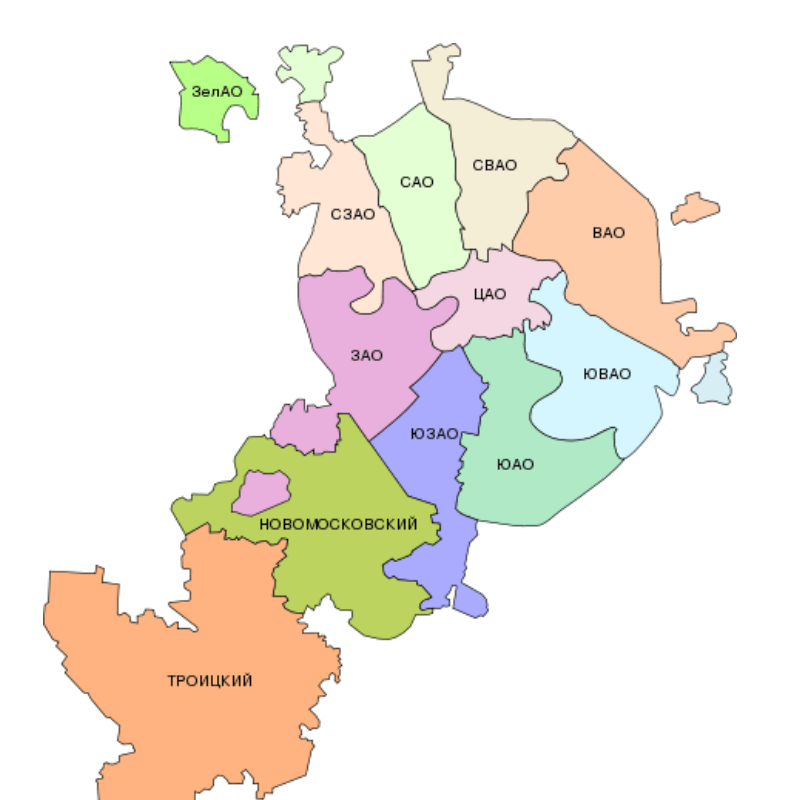

Цель нашего исследования изучить рынок предприятий общественного питания в Москве, поэтому я предлагаю **избавиться от всех заведений находящихся за ее пределами**, пусть даже они входят в ее административный округ. Дело в том, что стоимость той же самой аренды в центре Мосвкы выше, чем на ее окраинах. Потребности различаются. Всё это может повлиять на дельнейшее исследования.

In [27]:
# избавимся от всех заведений за территорией непосредственно города Москвы



rest_data = rest_data[~(rest_data['address'].str.contains('Зеленоград|д Московский|Троицк|Щербинка'))]

In [28]:
# уберем кафе адрес которых находится в деревне или поселении

rest_data = rest_data[~(rest_data['address'].str.contains('деревня|поселен'))]

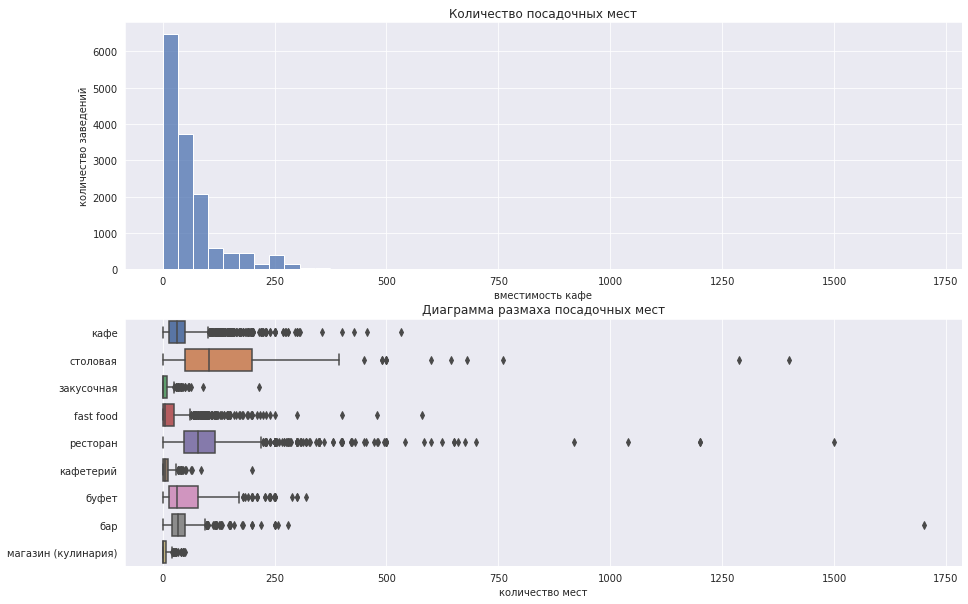

In [29]:
# изучим данные о количестве мест
# построим гистограмму и диаграмму размаха, чтобы изучить выбросы если есть

fig, ax = plt.subplots(2, 1, figsize=(15, 10))

ax1 = ax[0]
ax2 = ax[1]

sns.histplot(rest_data['number'], bins=50, ax=ax1)
ax1.set_title('Количество посадочных мест')
ax1.set_xlabel('вместимость кафе')
ax1.set_ylabel('количество заведений')


sns.boxplot(data=rest_data,x='number', y='object_type', ax=ax2)
ax2.set_title('Диаграмма размаха посадочных мест')
ax2.set_ylabel('')
ax2.set_xlabel('количество мест');



На графиках мы видим, что в данных присутствуют выбросы и причем для каждого типа кафе они свои, а также много заведений, где количество мест равняется 0.

Давайте создадим новую переменную **good_rest** в которую войдут следующие типы кафе по вместимости:

- кафе не более 100 мест,
- столовая не более 400 мест,
- закусочная не болеес 25 мест,
- fast food не более 50 мест,
- ресторан не более 220 мест,
- кафетерий не более 50 мест,
- буфет не более 180 мест,
- бар не более 100 мест,
- магазан (кулинария) не более 25 мест.

Кафе в которых количество мест и кафе с аномально большим количеством мест заменим на медиану.

In [30]:
# напишем небольшую функцию, которая заменит выбросы на медианы

def replace(
    data,          # указываем датафрейм
    column_1,      # столбец в нашем случае с типом кафе
    column_2,      # столбец в нашем случае с количеством мест
    types_1,       # здесь прописываем тип кафе
    types_2):      # здесь прописываем максимальное количество мест 
    
    # функция сделает срез данных и выбросы заменит на медиану
    # количество мест = 0 так же заменятся на медиану
    # медиану округлим до целого числа, чтобы сохранить тип данных int в столбце number
    
    
    data.loc[(
        
        (data[column_1] == types_1) & (
        (data[column_2] > types_2) | (data[column_2] < 1)
        )
    ), column_2] = round(data.loc[data[column_1] == types_1, column_2].median())
    
    

    
    return data

In [31]:
# создадим good_rest в которой выбросы по количеству мест приведем к медиане

good_rest = replace(rest_data, 'object_type', 'number', 'кафе', 100)
good_rest = replace(rest_data, 'object_type', 'number', 'столовая', 400)
good_rest = replace(rest_data, 'object_type', 'number', 'закусочная', 25)
good_rest = replace(rest_data, 'object_type', 'number', 'fast food', 50)
good_rest = replace(rest_data, 'object_type', 'number', 'ресторан', 220)
good_rest = replace(rest_data, 'object_type', 'number', 'кафетерий', 50)
good_rest = replace(rest_data, 'object_type', 'number', 'буфет', 180)
good_rest = replace(rest_data, 'object_type', 'number', 'бар', 100)
good_rest = replace(rest_data, 'object_type', 'number', 'магазин (кулинария)', 25)


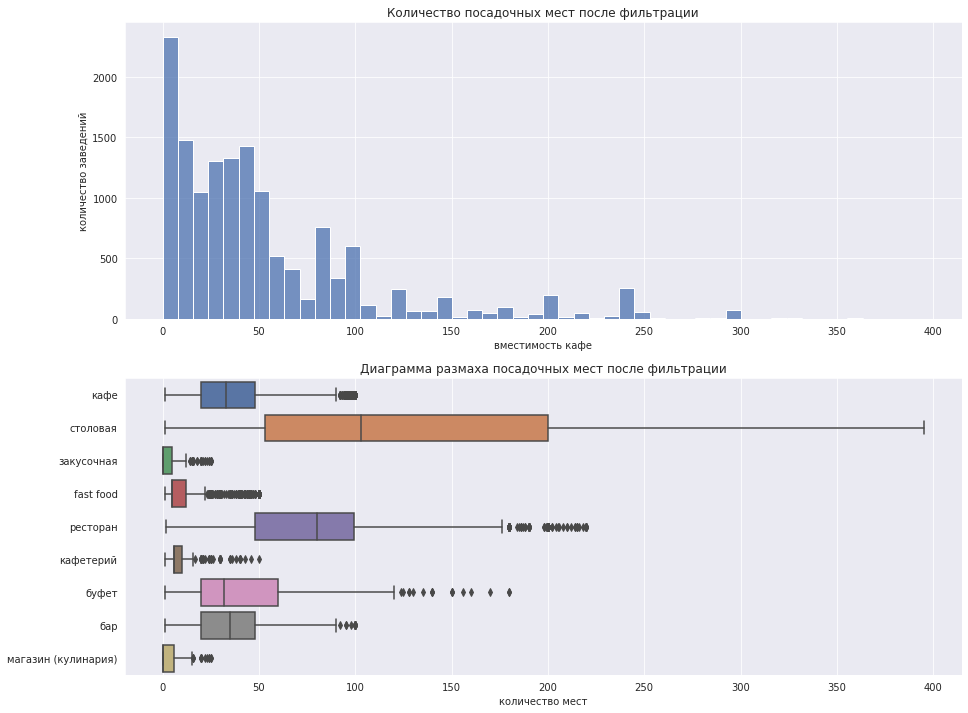

In [32]:
# построим гистограмму и диаграмму размаха по новой переменной good_rest и проверим функцию

fig, ax = plt.subplots(2, 1, figsize=(15, 12))

ax1 = ax[0]
ax2 = ax[1]

sns.histplot(good_rest['number'], bins=50, ax=ax1)
ax1.set_title('Количество посадочных мест после фильтрации')
ax1.set_xlabel('вместимость кафе')
ax1.set_ylabel('количество заведений')


sns.boxplot(data=good_rest,x='number', y='object_type', ax=ax2)
ax2.set_title('Диаграмма размаха посадочных мест после фильтрации')
ax2.set_ylabel('')
ax2.set_xlabel('количество мест');

Количество мест равное нулю и аномально вместительные кафе мы привели к медиане. В наборе данных еще встречались данные, где количество мест странно маленькие, но их мы изменять не будем, потому что мы не знаем всей картины, возможно ресторан начал работать на вынос, или же это уличный стрит фуд где поеть можно непосредственно рядом с ним у стойки. 

В любом случае мы создали новый датафрейм **good_rest** с которым и продолжим работать.

In [33]:
# проверим данные на дубликаты

print(f'''Количество дубликатов в good_rest: {good_rest.duplicated().sum()}''')

Количество дубликатов в good_rest: 0


<a id='3'></a>
## [3. Анализ данных](#content)

Давайте вспомним **цель нашего исследования:**
- Исследовать рынок используя открытые данные о заведениях общественного питания в Москве.

Рассмотрим информацию о данных:

In [34]:
# напишем общую информацию о датафрейме

print('''

В нашем распоряжении оказалось {} различных предприятий общественного питания в городе Москве.




В таблице собранны сетевые и не сетевые заведения:
- всего сетей {} и у них {} заведений, 
- не сетевых: {} заведений.

Процент всех сетевых заведений в исследовании составляет {:.2%}



В анализе участвуют следующие типы предприятий общественного питания: 
{}



Их количество по типам:

{}




'''.format(
    good_rest['id'].nunique(),
    good_rest.query('chain == True')['object_name'].nunique(),
    good_rest.query('chain == True')['id'].nunique(),
    good_rest.query('chain == False')['object_name'].nunique(),
    (good_rest.query('chain == True')['id'].nunique() / good_rest.query('chain == False')['id'].nunique()),
    good_rest['object_type'].unique().tolist(),
    good_rest.groupby('object_type')['id'].count().sort_values(ascending=False)
)
     
     
)



В нашем распоряжении оказалось 14538 различных предприятий общественного питания в городе Москве.




В таблице собранны сетевые и не сетевые заведения:
- всего сетей 450 и у них 2908 заведений, 
- не сетевых: 8828 заведений.

Процент всех сетевых заведений в исследовании составляет 25.00%



В анализе участвуют следующие типы предприятий общественного питания: 
['кафе', 'столовая', 'закусочная', 'fast food', 'ресторан', 'кафетерий', 'буфет', 'бар', 'магазин (кулинария)']



Их количество по типам:

object_type
кафе                   5727
столовая               2454
ресторан               2192
fast food              1824
бар                     827
буфет                   564
кафетерий               368
закусочная              331
магазин (кулинария)     251
Name: id, dtype: int64







### 3.1: Исследуем соотношение видов объектов общественного питания по количеству

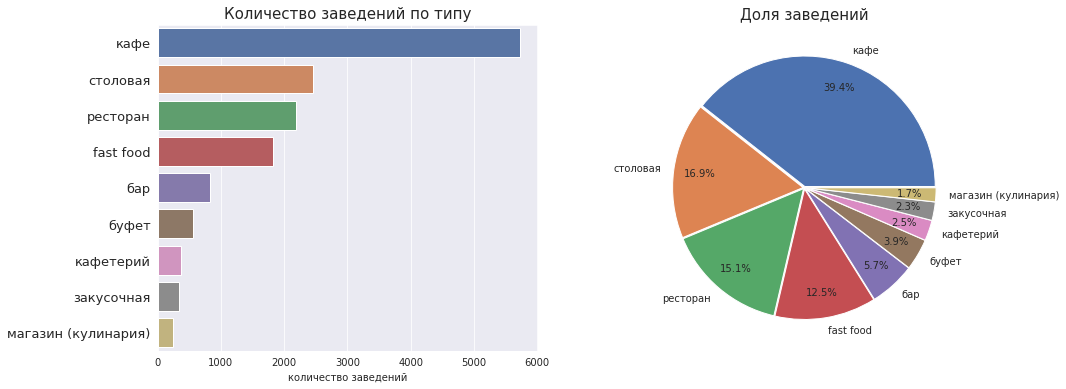

In [35]:
# построим графики

fig, ax = plt.subplots(1, 2, figsize=(15, 6))


ax1 = ax[0]
ax2 = ax[1]

data = good_rest.groupby('object_type', as_index=False)['id'].nunique().sort_values('id', ascending=False)


sns.barplot(data=data, y='object_type', x='id', ax=ax1)

ax1.set_title('Количество заведений по типу', size=15)
ax1.set_xlabel('количество заведений')
ax1.set_ylabel('')
ax1.set_yticklabels(ax1.get_yticklabels(), size=13)

labels=data['object_type']

plt.pie(x='id', data=data, autopct='%.1f%%', pctdistance=0.8, explode=[.01] * len(labels), labels=labels)
plt.title('Доля заведений', size=15);


На графике видно, что среди всех типов типов объектов общественного питания около половины рынка занимают всего два:
- **кафе** примерно **40%**,
- **столовая** примерно **17%**.

Остальные заведения делять оставшуюся половину рынка, но среде них **около 30% рынка занимают рестораны и фастфуды**.

Такие типы заведений как: буфеты, кафетерии, закусочные и отделы кулинарии в магазинах каждый по отдельности не занимает даже **5%** от общей доли на рынке.

### 3.2: Исследуем соотношение сетевых и несетевых заведений по количеству

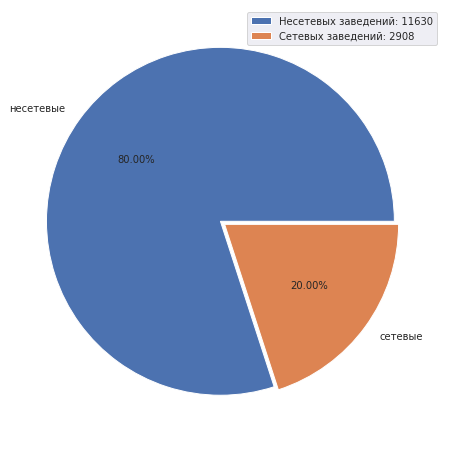

In [36]:
# построим гистограммы соотношение сетевых и несетевых заведений по количеству

fig, ax = plt.subplots(figsize=(8,8))

data = good_rest.groupby('chain', as_index=False)['id'].nunique()

labels = ['несетевые', 'сетевые']

plt.pie(data=data, x='id', labels=labels, autopct='%.2f%%', explode=[.03, 0])

plt.legend([f'Несетевых заведений: {data.query("chain == False")["id"].sum()}',
            f'Сетевых заведений: {data.query("chain == True")["id"].sum()}'
           ]);



Ранее мы считали долю сетевых заведений процентов и она была около **25%**, на графике она указанна около **20%**.

Примерная доля сетевых заведений в наших данных: **20-25%%**.

### 3.3: Для какого вида объекта общественного питания характерно сетевое распространение?

In [37]:
# подготовим данные, чтобы указать указать долю типа сетевого заведения от их общего количества

# сгруппируем

chain = (good_rest
         .query('chain == True')[['id', 'chain', 'object_type']]
         .groupby(['chain', 'object_type'])
         .agg({'id': 'count'}).reset_index()).sort_values('object_type')

non_chain = (good_rest
         .query('chain == False')[['id', 'chain', 'object_type']]
         .groupby(['chain', 'object_type'])
         .agg({'id': 'count'}).reset_index()).sort_values('object_type')


# соеденим

data = chain.merge(non_chain[['object_type', 'id']], on='object_type', how='left', suffixes=['_chain', '_non_chain'])

# посчитаем общее количество заведений

data['count_cafe'] = data['id_chain'] + data['id_non_chain'] 


# узнаем процент сетевых типов 

data['id_non_chain'] = (data['id_chain'] / data['count_cafe'] * 100)

# отсортируем, чтобы на графике смотрелось кравиво

data = data.sort_values('id_non_chain', ascending=False)


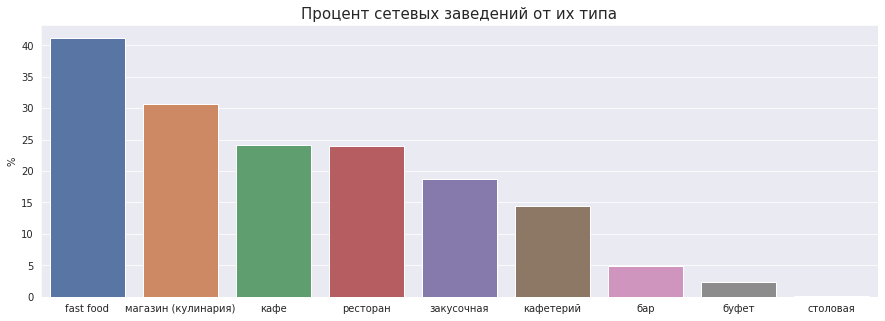

In [38]:
# построим график соотношения вида и сетевое расположение


fig, ax = plt.subplots(figsize=(15,5))


sns.barplot(
    data=data, 
    x='object_type',
    y='id_non_chain', 
    
    ax=ax)


ax.set_title('Процент сетевых заведений от их типа', size=15)
ax.set_xlabel('')
ax.set_ylabel('%');

Примерно **40%** всех фастфуд заведений - сетевые.

Около **30%** сетевые магазины (отдел кулинария).

Около **25%** среди кафе и ресторанов - сетевые.

Сетевые предприятия не любят бары - их доля около **5%**, в бучетах и столов еще меньше.

### 3.4: Что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?

In [39]:
# подготовим данные для графика, сгруппируем по названию заведения, посчитаем их количество и среднею вместимость

data = (
    good_rest
    .query('chain == True')
    .groupby('object_name', as_index=False)
    .agg({'id': 'count','number': 'mean','object_type': 'first'})
)

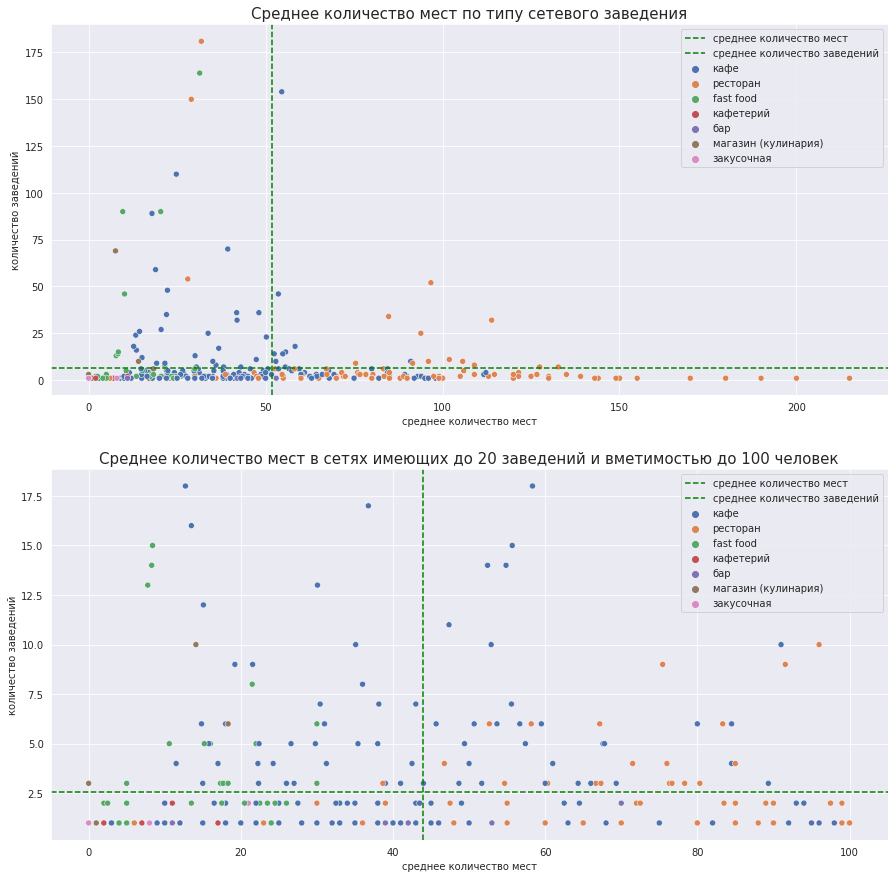

In [40]:
fig, ax = plt.subplots(2, 1, figsize=(15, 15))

ax1 =ax[0]
ax2 = ax[1]

sns.scatterplot(data=data, x='number', y='id', ax=ax1, hue='object_type' )
ax1.set_title('Среднее количество мест по типу сетевого заведения', size=15)
ax1.set_ylabel('количество заведений')
ax1.set_xlabel('среднее количество мест')
ax1.axvline(x=data['number'].mean(), linestyle='--', color='g', label='среднее количество мест')
ax1.axhline(y=data['id'].mean(), linestyle='--', color='g', label = 'среднее количество заведений')
ax1.legend()

data = data.query('number <= 100 and id <= 20')

sns.scatterplot(data=data, x='number', y='id', ax=ax2, hue='object_type' )
ax2.set_title('Среднее количество мест в сетях имеющих до 20 заведений и вметимостью до 100 человек', size=15)
ax2.set_ylabel('количество заведений')
ax2.set_xlabel('среднее количество мест')
ax2.axvline(x=data['number'].mean(), linestyle='--', color='g', label='среднее количество мест')
ax2.axhline(y=data['id'].mean(), linestyle='--', color='g', label = 'среднее количество заведений')
ax2.legend();

Мы построили два графика:
- в верхнем мы видим соотношения количества мест и количество мест характерное типу заведения, 
- на нижнем представлено соотношение у заведений вместимостью до 100 человек.

**Мы видим:**
- показатели выше среднего встречаются только у кафе и ресторанов - заведения этого типа предлагают больший ассортимент продукции и более комфортные условия,
- фастфудам отнють намного важнее количество заведений, и их показатель по вместимости не предусмотрем на вместимость более 30 мест,
- остальные типы имеют показатели меньше средних значений им характерно: малое количество мест до 40 и относительно небольшое количество заведений до 10, но также есть и исключения, но их слишком мало.


Мы можем сказать, что количество мест в сетевых заведениях различается по типу.

### 3.5: Для каждого вида объекта общественного питания опишите среднее количество посадочных мест. Какой вид предоставляет в среднем самое большое количество посадочных мест?

Выше мы построили график, но на нем изображенны только сетевые заведения, давайте взглянем на общую картину по Москве.

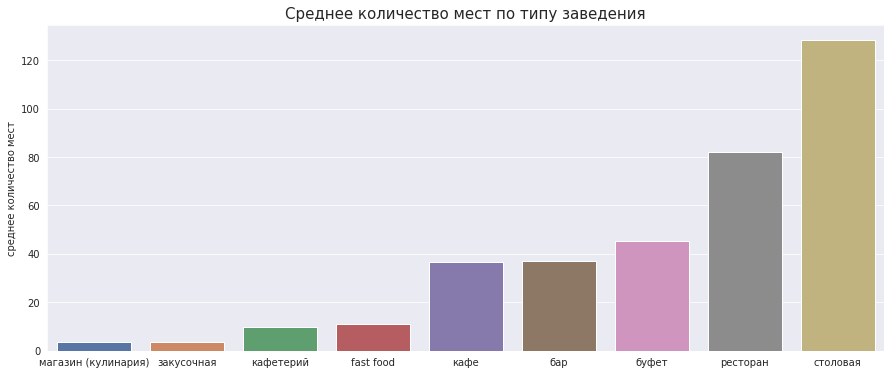

In [41]:
fig, ax = plt.subplots(figsize=(15, 6))

data = good_rest.groupby('object_type', as_index=False).agg({'id': 'nunique', 'number': 'mean'}).sort_values('number')

sns.barplot(data=data, x='object_type', y='number')
ax.set_title('Среднее количество мест по типу заведения', size=15)
ax.set_ylabel('среднее количество мест')
ax.set_xlabel('');

В общей картине ситуация меняется:
- столовым характерно иметь большее количество мест, как и мыбо с сетевыми заведениями,
- на втором месте рестораны, которые в среднем имеют количество мест равное 80,
- здесь выделяются буфеты и бары, их количество мест выше, чем у фастфудов и кафе.

### 3.6: Выделите в отдельный столбец информацию об улице из столбца address

In [42]:
# воспользуемся методом сплит и разделим строки по запятым, в большинстве случаем сначала идет город, а потом улица в адресе
# вытянем из списка второе значение, которое должно начинаться с улицы
# выведем на экран таблицу и узучим ее

good_rest['street'] = good_rest['address'].str.split(',', expand=True)[1]
good_rest['street'].value_counts().head(10)

 проспект Мира             204
 Профсоюзная улица         182
 Ленинградский проспект    171
 Пресненская набережная    167
 Варшавское шоссе          161
 Ленинский проспект        147
 проспект Вернадского      132
 Кутузовский проспект      114
 Каширское шоссе           112
 Кировоградская улица      110
Name: street, dtype: int64

### 3.7: Постройте график топ-10 улиц по количеству объектов общественного питания. Воспользуйтесь внешней информацией и ответьте на вопрос — в каких районах Москвы находятся эти улицы?

In [43]:
# в нашем распоряжении оказалась внешняя таблица с общепитами Москвы, я добавил ее в самое начало и назвал df
# соеденим эти таблицы по нашим id и добавим район Москвы, где есть эти заведения

df.columns = df.columns.str.lower()
df = df.query('id != "Код"')
df['id'] = df['id'].astype('int64')

In [44]:
# соеденим таблицу по id

good_rest = good_rest.merge(df[['id', 'district']], on='id', how='left')

In [45]:
# удалим пропущенные значения

good_rest.dropna(axis=0, inplace=True)

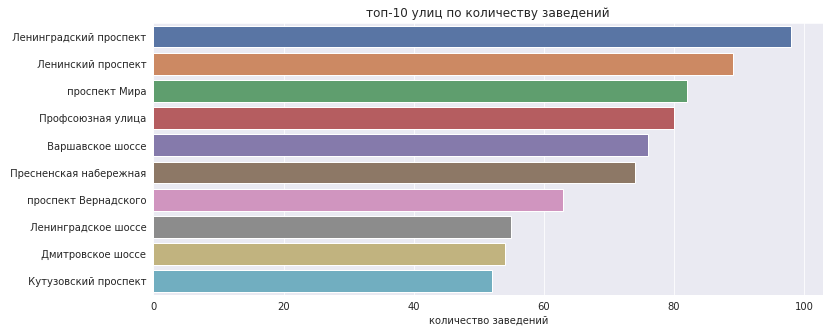

In [46]:
# построим график Топ-10 улиц по количеству объектов

data = good_rest.groupby('street', as_index=False).agg(
    {
        'id': 'nunique',
        'district': 'unique'
    })


top_street = data.sort_values('id', ascending=False).head(10)


fig, ax = plt.subplots(figsize=(12,5))

sns.barplot(data=top_street, x='id', y='street')
ax.set_title('топ-10 улиц по количеству заведений')
ax.set_xlabel('количество заведений')
ax.set_ylabel('');


In [47]:
# выведем на экран районы этих улиц

top_street[['street', 'district']].reset_index(drop=True)

,street,district
0,Ленинградский проспект,"[район Беговой, район Аэропорт, район Сокол, Хорошёвский район]"
1,Ленинский проспект,"[район Якиманка, Донской район, Гагаринский район, Ломоносовский район, Обручевский район, район Тропарёво-Никулино, район Тёплый Стан, район Проспект Вернадского]"
2,проспект Мира,"[Мещанский район, Останкинский район, Алексеевский район, район Свиблово, район Ростокино]"
3,Профсоюзная улица,"[Академический район, район Черёмушки, район Тёплый Стан, район Коньково, Обручевский район, район Ясенево]"
4,Варшавское шоссе,"[Донской район, Нагорный район, район Чертаново Южное, район Чертаново Центральное, район Чертаново Северное, район Южное Бутово, район Нагатино-Садовники]"
5,Пресненская набережная,[Пресненский район]
6,проспект Вернадского,"[Ломоносовский район, район Тропарёво-Никулино, район Проспект Вернадского, поселение Вороновское, район Раменки]"
7,Ленинградское шоссе,"[район Сокол, Войковский район, район Левобережный, Головинский район, Молжаниновский район]"
8,Дмитровское шоссе,"[Тимирязевский район, Бескудниковский район, Дмитровский район, район Восточное Дегунино, район Северный, район Западное Дегунино, район Лианозово]"
9,Кутузовский проспект,"[район Дорогомилово, район Фили-Давыдково, поселение Краснопахорское]"


Подробнее по районам:

- `проспект Мира` - это районы: **Мещанский, Марьина Роща, Алексеевский, Останкинский, Свиблово, Ростокино**, улица протяженностью примерно 9 км. на севере Москвы;


- `Профсоюзная улица` - это районы: **Академический, Коньково, Обручевский, Тёплый Стан, Черёмушки, Ясенево**, улица протяженностью примерно 9 км. на юго-западе Москвы;


- `Ленинградский проспект` - это районы: **Беговой, Аэропорт, Сокол, Хорошёвский**, улица протяженностью примерно 6 км. на северо-западе Москвы;


- `Пресненская набережная` - это район **Пресненский**, улица протяженностью примерно 500м на западе Москвы;


- `Варшавское шоссе` - улица длиною почти 23 км., проходит через районы: **Донской, Нагатино-Садовники, Нагорный, Чертаново Северное, Чертаново Центральное, Чертаново Южное ЮАО и Северное Бутово, Южное Бутово ЮЗАО, далее по ТиНАО**;


- `Ленинский проспект` - это районы **Якиманка, Донской, Гагаринский, Ломоносовский, Обручевский, Тёплый Стан, Проспект Вернадского, Тропарёво-Никулино**, улица протяженностью 14км на юго-западе Москвы;


- `проспект Вернадского` - это районы: **Гагарински, Ломоносовский, Раменки, Проспект Вернадского, Тропарёво-Никулино**, улица протяженностью 8 км. на юго-западе Москвы;


- `Кутузовский проспект` - это районы: **Дорогомилово, Фили-Давыдково**, улица протяженностью примерно 8 км. на западе Москвы;


- `Каширское шоссе` - это район **Москворечье-Сабурово, Орехово-Борисово Северное, Орехово-Борисово Южное, Нагатино-Садовники**, шоссе протяженностью 12 км. на юге Москвы;


- `Кировоградская улица` - это районы **Чертаново Северное, Чертаново Центральное, Чертаново Южное**, улица протяженностью примерно 4 км. на юге Москвы.






[иточник Википедия](https://ru.wikipedia.org/wiki/Заглавная_страница)

Исходя из описание улиц выше, мы видим, что отличительнной причиной их популярности может быть их длинна, потмому что они затрагиваю не один район и даже не два, а 4 и даже большее. 

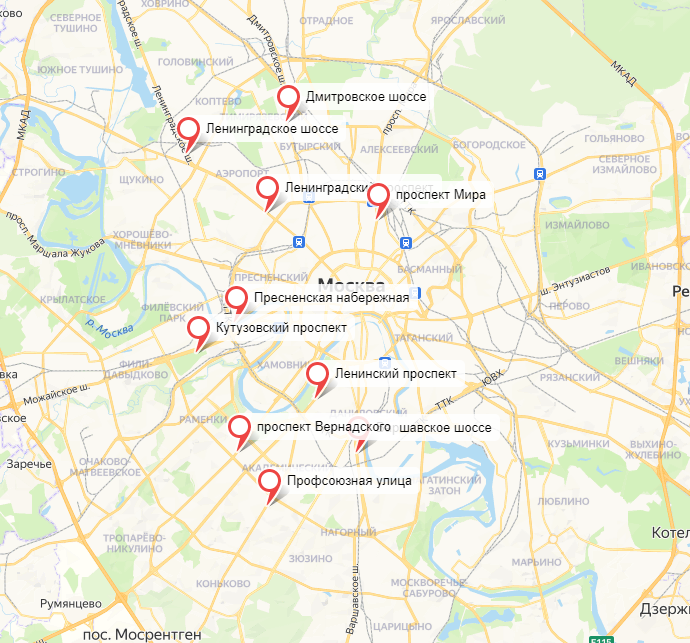


Если мы посмотрим на их расположении на карте, то можем увидеть, что эти улицы примыкают к центу Москвы либо сами, либо через другие смежные улицы. Можно сказать, что это транспортные артерии Москвы, длиное в несколько км.

Среди них есть 1 исключение - это Пресненская набережная протяженностью не более 500 м, но она распологается рядом с Москва-Сити - одним из популярнейших мест в Москве. 

### 3.8: Найдите число улиц с одним объектом общественного питания. Воспользуйтесь внешней информацией и ответьте на вопрос — в каких районах Москвы находятся эти улицы?

In [48]:
# создадим переменную в которой сгруппируем по улицам и укажем район и число заведений


street_empty = (
    good_rest
    .groupby('street', as_index=False)
    .agg({'district': 'first', 'id': 'nunique'})
    .rename(columns = {'id': 'count_cafe'})
    .sort_values('count_cafe')

)
    

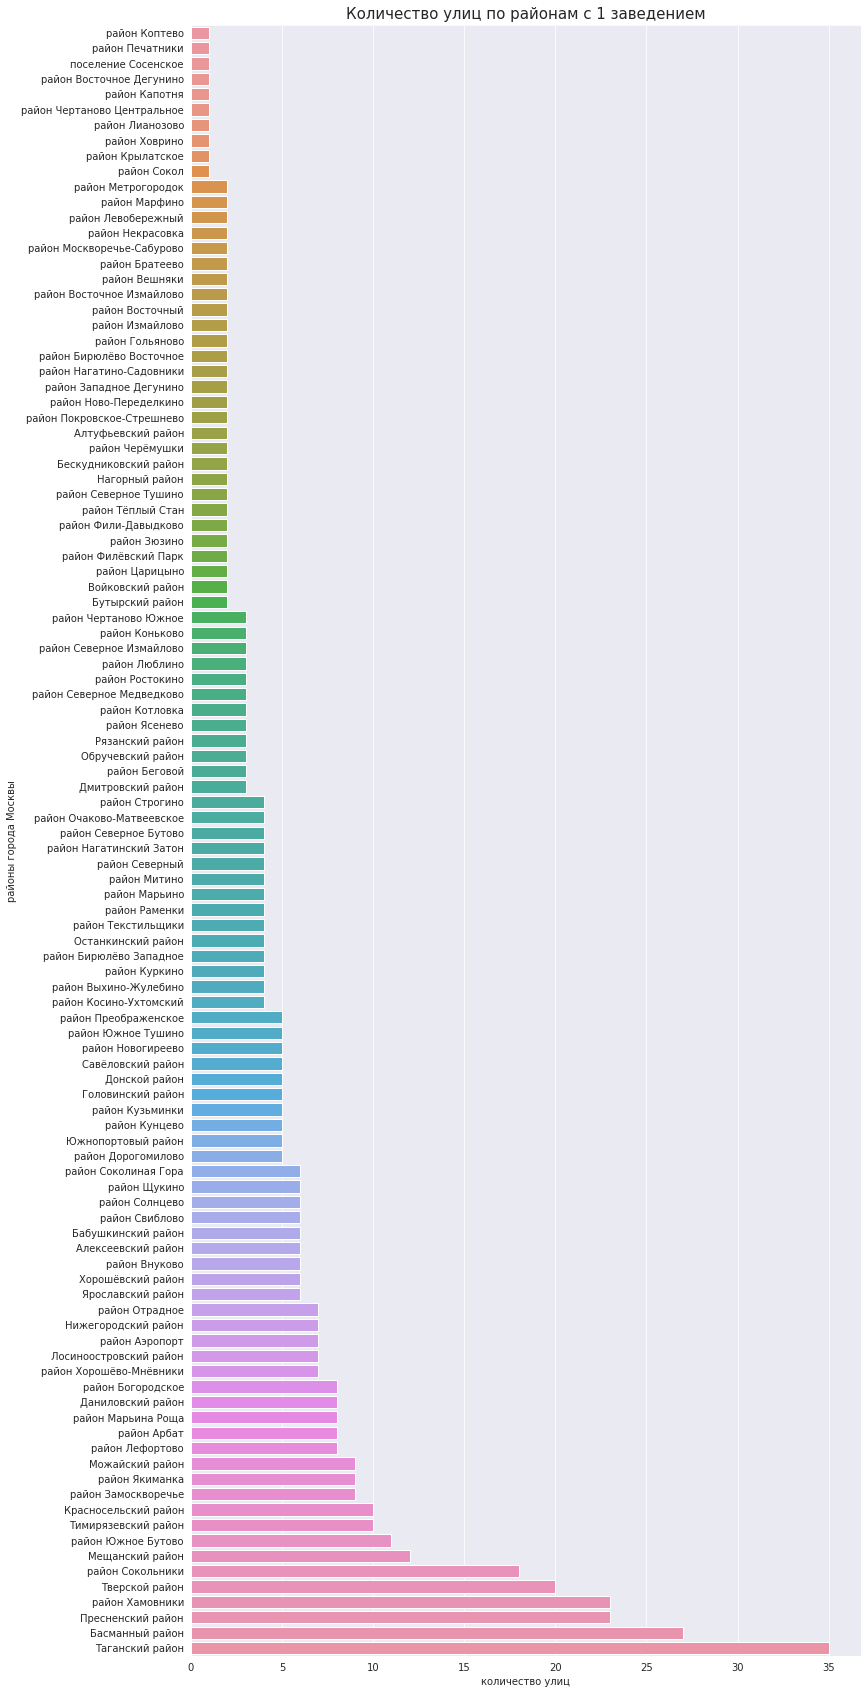

In [49]:
# узнаем в каких районах всего 1 заведение

data = street_empty.query('count_cafe == 1').groupby('district', as_index=False)['street'].nunique().sort_values('street')

plt.figure(figsize=(12,30))

sns.barplot(data=data, x='street', y='district')
plt.title('Количество улиц по районам с 1 заведением', size=15)
plt.xlabel('количество улиц')
plt.ylabel('районы города Москвы');


Судя по графику у нас есть четыре района в которых более чем на 20 улицах всего 1 заведение:
- Преснесенский, Хамовники, Басманный и Таганский - в этих районах на одной улице меньше всего заведений. 

### Посмотрите на распределение количества посадочных мест для улиц с большим количеством объектов общественного питания. Какие закономерности можно выявить?

In [50]:
# создадим streers и добавим по индексам количество мест

streets = pd.merge(street_empty, good_rest['number'], left_index=True, right_index=True, how='inner')

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


''

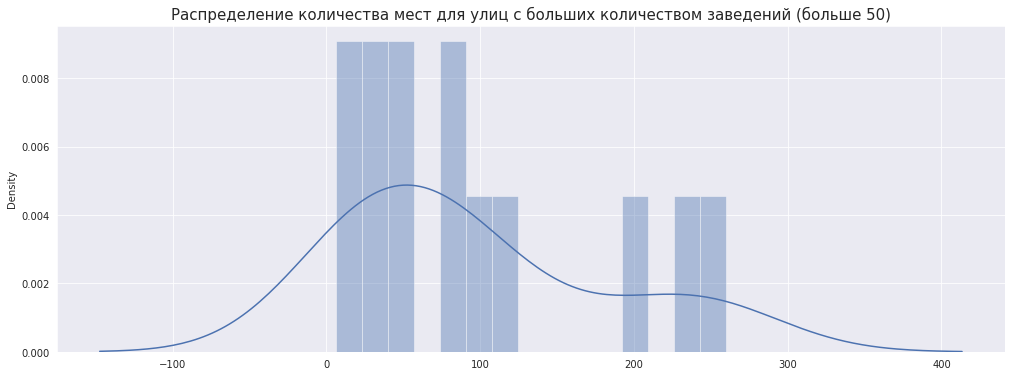

In [51]:
# построим график и посмотрим на распределение

fig, ax = plt.subplots(figsize=(17, 6))

# ранее мы пришли к выводу, что 40 объектов питание на одной улице это выше среднего, сделаем срез

data = streets.query('count_cafe >= 40')

sns.distplot( data['number'], ax=ax, bins=15)
ax.set_title('Распределение количества мест для улиц с больших количеством заведений (больше 50)', size=15)
ax.set_xlabel('вместимость кафе')
ax.set_xlabel('')


;

Видим, что распределение близко к нормальному, но на нее влияют выбросы - заведения с количеством мест более 200, в предобработке мы выяснили, что такие заведения скорее ввсего принадлежат к типу **столовая**, их немного.

Без выбросов - было бы похоже на нормальное распределение с мат ожиданием около 40-50 мест.

### Вывод: 


**В ходе исследования мы выяснили:**

**1. Если рассматривать количества объектов питание по типу, то здесь около половины рынка занимают всего два:**
- **кафе** примерно **40%**,
- **столовая** примерно **17%**.

Остальные заведения делять оставшуюся половину рынка, но среде них **около 30% рынка занимают рестораны и фастфуды**.

Такие типы заведений как: буфеты, кафетерии, закусочные и отделы кулинарии в магазинах каждый по отдельности не занимает даже **5%** от общей доли на рынке.


**2. Что касается сетевых объектов питание, то их доля примерно составляет: 20%-25%.**
- 2.1: Сетевые предприятия предпочитают следующие типы заведений:
 - **40%** всех фастфуд заведений - сетевые.
 - **30%** сетевые магазины (отдел кулинария).
 - **25%** среди кафе и ресторанов - сетевые.
 - Сетевые предприятия не любят бары - их доля около **5%**, в бучетах и столов еще меньше.
  
  
- 2.2: Что касается вместимости сетевых объектов:
 - **Мы видим:**
  - показатели выше среднего встречаются только у кафе и ресторанов - заведения этого типа предлагают больший ассортимент продукции и более комфортные условия,
  - фастфудам отнють намного важнее количество заведений, и их показатель по вместимости не предусмотрем на вместимость более 30 мест,
  - остальные типы имеют показатели меньше средних значений им характерно: малое количество мест до 40 и относительно небольшое количество заведений до 10, но также есть и исключения, но их слишком мало.


Мы можем сказать, что количество мест в сетевых заведениях различается по типу.



**3. В общей картине ситуация вокруг вместимости сетевых и несетевых заведений меняется:**
 - столовым характерно иметь большее количество мест, как и мыбо с сетевыми заведениями,
 - на втором месте рестораны, которые в среднем имеют количество мест равное 80,
 - здесь выделяются буфеты и бары, их количество мест выше, чем у фастфудов и кафе.
 
**4. Мы также посмотрели концентрацию количества заведений на одной улице и ниже представлен список улиц и районов с самой большой концентрацией:**

- `проспект Мира` - это районы: **Мещанский, Марьина Роща, Алексеевский, Останкинский, Свиблово, Ростокино**, улица протяженностью примерно 9 км. на севере Москвы;


- `Профсоюзная улица` - это районы: **Академический, Коньково, Обручевский, Тёплый Стан, Черёмушки, Ясенево**, улица протяженностью примерно 9 км. на юго-западе Москвы;


- `Ленинградский проспект` - это районы: **Беговой, Аэропорт, Сокол, Хорошёвский**, улица протяженностью примерно 6 км. на северо-западе Москвы;


- `Пресненская набережная` - это район **Пресненский**, улица протяженностью примерно 500м на западе Москвы;


- `Варшавское шоссе` - улица длиною почти 23 км., проходит через районы: **Донской, Нагатино-Садовники, Нагорный, Чертаново Северное, Чертаново Центральное, Чертаново Южное ЮАО и Северное Бутово, Южное Бутово ЮЗАО, далее по ТиНАО**;


- `Ленинский проспект` - это районы **Якиманка, Донской, Гагаринский, Ломоносовский, Обручевский, Тёплый Стан, Проспект Вернадского, Тропарёво-Никулино**, улица протяженностью 14км на юго-западе Москвы;


- `проспект Вернадского` - это районы: **Гагарински, Ломоносовский, Раменки, Проспект Вернадского, Тропарёво-Никулино**, улица протяженностью 8 км. на юго-западе Москвы;


- `Кутузовский проспект` - это районы: **Дорогомилово, Фили-Давыдково**, улица протяженностью примерно 8 км. на западе Москвы;


- `Каширское шоссе` - это район **Москворечье-Сабурово, Орехово-Борисово Северное, Орехово-Борисово Южное, Нагатино-Садовники**, шоссе протяженностью 12 км. на юге Москвы;


- `Кировоградская улица` - это районы **Чертаново Северное, Чертаново Центральное, Чертаново Южное**, улица протяженностью примерно 4 км. на юге Москвы.

**5. В ходе исследования мы обнаружили района в которых более чем на 20 улицах всего 1 заведение:**
- Преснесенский, 
- Хамовники, 
- Басманный,
- Таганский.


**6. Проанализировав улицы на которых расположенно больше всего заведений:**
 - обнаружили, что распределение близко к нормальному, но на нее влияют выбросы - заведения с количеством мест более 200, в предобработке мы выяснили, что такие заведения скорее ввсего принадлежат к типу **столовая**, их немного. Без выбросов - было бы похоже на нормальное распределение с мат ожиданием около 40-50 мест.
 
 
 
**Общий итог:**

Если соотнести всю информацию, то можно сказать, что больше всего распространенны несетевые заведения, по большей частности относящиеся к тип:

- **Кафе** — это предприятие общественного питания по организации питания и отдыха потребителей с предоставлением ограниченного по сравнению с рестораном ассортимента продукции, реализующее фирменные, заказные блюда, алкогольные и безалкогольные напитки;

- что касается **вместимости**, то в среднем у заведений этого типа она **не превышает 40** посадочных мест;

- в исследовании мы видили, что есть улицы и районы с большой концентрацией всех типов заведений птания, но также есть районы в которых достаточно мало заведений:

 - **Пресненский район**,
 - **Хамовники**,
 - **Басманный район**,
 - **Таганский район**.
 
Все эти районы расположены рядом с центом Москвы.
 


<a id='4'></a>
## [4. Презентация](#content)

Презентация проекта: [Исследование предприятий общественного птания](https://drive.google.com/file/d/1K4DkcfSth6FOHuEznIdaEQ7GQHNUO2DM/view?usp=sharing)